## Global Cells

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# optional but useful if you want to use larger models
# !MAX_JOBS=4 pip install flash-attn --no-build-isolation


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 87.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.2.post1-cp310-cp310-linux_x86_64.whl size=190160474 sha256=0b454d9e650bfc437cc71335080172a5d05f51eab355636c9d5b7321fec7318e
  Stored in directory: /root/.cache/pip/wheels/da/ec/5b/b2c37a8e4f755ad82492a822463bca0817f0e0e11de874b550
Successfully built flash-attn


In [ ]:
!pip install git+https://github.com/tlebryk/IE-UQ.git@develop

  Cloning https://github.com/tlebryk/IE-UQ.git (to revision develop) to /tmp/pip-req-build-5d4a04pk
  Running command git clone --filter=blob:none --quiet https://github.com/tlebryk/IE-UQ.git /tmp/pip-req-build-5d4a04pk
  Resolved https://github.com/tlebryk/IE-UQ.git to commit fce63c903043d6015fa813ad9d874a22c0d78fa2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/tlebryk/NERRE.git (to revision dev) to /tmp/pip-install-8or5tpf_/nerre_ffb6173d6f764bd8897a4034d3de85fe
  Running command git clone --filter=blob:none --quiet https://github.com/tlebryk/NERRE.git /tmp/pip-install-8or5tpf_/nerre_ffb6173d6f764bd8897a4034d3de85fe
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/tlebryk/NERRE.git to commit 65c198a5a06793673ab0483bd023b59ef72f3c22
 

In [ ]:
# hot reload IE_UQ library code using this cell
!pip install --no-deps --no-cache-dir --force-reinstall git+https://github.com/tlebryk/IE-UQ.git@develop

  Cloning https://github.com/tlebryk/IE-UQ.git (to revision develop) to /tmp/pip-req-build-lvpakezx
  Running command git clone --filter=blob:none --quiet https://github.com/tlebryk/IE-UQ.git /tmp/pip-req-build-lvpakezx
  Resolved https://github.com/tlebryk/IE-UQ.git to commit 491c498fc4f3ccebc652cfc1eb73d38f14c447c0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ie_uq: filename=ie_uq-0.1.0-py3-none-any.whl size=19084 sha256=1fe81951eb516015a75663e302f5c6d1d4f60c5b86f3e2a7b411211b286d5c5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-kuqzqp4k/wheels/62/df/ad/b7794a681c1bee4855a049d458bcaf08e14e92cc09a2382315
Successfully built ie_uq
  Attempting uninstall: ie_uq
    Found existing installation: ie_uq 0.1.0
    Uninstalling ie_uq-0.1.0:
      Successfully uninstalled ie_uq-0.1.0


In [ ]:
# hot reload eval code
!pip install --no-deps --no-cache-dir --force-reinstall "nerre[dev] @ git+https://github.com/tlebryk/NERRE.git@dev"

  Cloning https://github.com/tlebryk/NERRE.git (to revision dev) to /tmp/pip-install-j373rg4d/nerre_e89803a681ee4e13a0f495b173a09082
  Running command git clone --filter=blob:none --quiet https://github.com/tlebryk/NERRE.git /tmp/pip-install-j373rg4d/nerre_e89803a681ee4e13a0f495b173a09082
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/tlebryk/NERRE.git to commit 0193720000e07ac560aa61ab29afff25f4c914fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nerre: filename=nerre-0.1.2-py3-none-any.whl size=20151 sha256=a4add34c9b3c02755360ac5f29e3512af090a41fe5c89288bd6caead193ddf22
  Stored in directory: /tmp/pip-ephem-wheel-cache-9jrtkonx/wheels/fd/d1/9b/6df9fd753060f4ab318fb0583514c3372d4a6ba0d53458387f
Successfully built nerre
  Attempting uninstal

In [ ]:
import os
from ie_uq import few_shot_inference, few_shot_inference_extraction, synthetic_data, uq_score, experiment_sampling, uq_utils
from doping import step3_score
import argparse
import torch
from transformers import GenerationConfig, AutoConfig


In [ ]:
# llama models recommended; alternate experiment uses Llama-3.1-8B-Instruct
model_id = "meta-llama/Llama-3.2-3B-Instruct"

dataset_path = '/content/drive/MyDrive/nlp/Final_project/IE-UQ/runs/random-100-dataset/train_dataset.jsonl'
inference_dataset_path: str = '/content/drive/MyDrive/nlp/Final_project/IE-UQ/runs/random-100-dataset/train_dataset.jsonl'
mode="synth_json"
output_dir = "/content/drive/MyDrive/nlp/Final_project/IE-UQ/runs"
bnb_dict = {}
peft_dict = None
sft_dict = None
model_dict = None
model_config = AutoConfig.from_pretrained(model_id)
# use deterministic greedy decoding for generation to maximize reproducibility
extraction_generation= {
            "max_new_tokens": 150,
            "do_sample": False,
            "eos_token_id": model_config.eos_token_id,
        }

generation_dict = None
budget = 100

# train longer for extraction and synth span=
extraction_sft = {
    "output_dir": output_dir,  # output directory
    "num_train_epochs": 10,  # number of training epochs
    "per_device_train_batch_size": 4,  # batch size per device during training
    "gradient_accumulation_steps": 2,  # number of steps before performing a backward/update pass
    "gradient_checkpointing": True,  # use gradient checkpointing to save memory
    "optim": "adamw_torch_fused",  # use fused adamw optimizer
    "logging_steps": 10,  # log every 10 steps
    "save_strategy": "epoch",  # save checkpoint every epoch
    "learning_rate": 2e-4,  # learning rate, based on QLoRA paper
    "bf16": True,  # use bfloat16 precision
    "max_grad_norm": 0.3,  # max gradient norm based on QLoRA paper
    "warmup_ratio": 0.03,  # warmup ratio based on QLoRA paper
    "lr_scheduler_type": "constant",  # use constant learning rate scheduler
    "push_to_hub": False,  # push model to hub
    "report_to": "tensorboard",  # report metrics to tensorboard
    "max_seq_length": 512,
}

# synthetic json training
# under train (4 epochs) so we don't overfit to existing data
sft_synth_json = {
            "output_dir": output_dir,  # output directory
            "num_train_epochs": 4,  # number of training epochs
            "per_device_train_batch_size": 2,  # batch size per device during training
            "gradient_accumulation_steps": 2,  # number of steps before performing a backward/update pass
            "gradient_checkpointing": True,  # use gradient checkpointing to save memory
            "optim": "adamw_torch_fused",  # use fused adamw optimizer
            "logging_steps": 10,  # log every 10 steps
            "save_strategy": "epoch",  # save checkpoint every epoch
            "learning_rate": 2e-4,  # learning rate, based on QLoRA paper
            "bf16": True,  # use bfloat16 precision
            # 'tf32': True,                              # use tf32 precision
            "max_grad_norm": 0.3,  # max gradient norm based on QLoRA paper
            "warmup_ratio": 0.03,  # warmup ratio based on QLoRA paper
            "lr_scheduler_type": "constant",  # use constant learning rate scheduler
            "push_to_hub": False,  # push model to hub
            "report_to": "tensorboard",  # report metrics to tensorboard
            # "packing": True,
            "max_seq_length": 512,
            # 'dataset_kwargs': {'skip_prepare_dataset': True}
}
# intermediate directories where we store the synthetic jsons and spans respectively
synth_json_dir =  os.path.join(output_dir, "synth_json_gen_10_ep")
synth_span_dir =  os.path.join(output_dir, "synth_span_gen_10_ep")

# final dictectories which hold the final adapters and performance scores.
# change the final folder to save to a new "trial" folder
random_baseline_dir = os.path.join(output_dir, "random_baseline_uq_results_10_ep")
active_learning_dir = os.path.join(output_dir, "active_learning_uq_results_10_ep")
synth_span_dir_final = os.path.join(output_dir, "synth_extraction_ft_10_ep")

# use small="small" and quick_mode =True to run in an abbreviated mode which can quickly verify certain functionality.
small = ''
quick_mode=False

test_dataset_path_local = f'/content/drive/MyDrive/nlp/Final_project/NERRE/doping/data/test{small}.json'
test_dataset_path = f"https://raw.githubusercontent.com/tlebryk/NERRE/refs/heads/dev/doping/data/test{small}.json"


## Random baseline

In [ ]:
# RANDOM BASELINE SAMPLING
experiment_sampling.main(
    dataset_path=dataset_path,
    sampling_mode="random",
    output_dir=random_baseline_dir,
    budget=budget,
)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# RANDOM BASELINE TRAINING
synthetic_data.main(
    model_id=model_id,
    dataset_path=os.path.join(random_baseline_dir, "train_dataset.jsonl"),
    mode="extraction",
    output_dir=random_baseline_dir,
    bnb_dict=bnb_dict,
    peft_dict=peft_dict,
    sft_dict=extraction_sft,
    model_dict=model_dict,
    generation_dict=generation_dict
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Original Output: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 Dec 2024

Extract doping information from this sentence into a json. Respond with the exact answer only, no explanations or prefixes.<|eot_id|><|start_header_id|>user<|end_header_id|>

In this paper, we propose a model for estimating short-channel effects (SCEs) in the shell-doped double-gate junctionless (JL) MOSFET<|eot_id|><|start_header_id|>assistant<|end_header_id|>

`{"doping": "shell-doped", "type": "double-gate", "junction": "junctionless", "mosfet": "MOSFET"}


Map:   0%|          | 0/90 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,0.702500
20,0.128700
30,0.056100
40,0.062400
50,0.034600
60,0.044700
70,0.038800
80,0.019300
90,0.020400
100,0.018400


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/

Finetuned Output: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 Dec 2024

Extract doping information from this sentence into a json. Respond with the exact answer only, no explanations or prefixes.<|eot_id|><|start_header_id|>user<|end_header_id|>

In this paper, we propose a model for estimating short-channel effects (SCEs) in the shell-doped double-gate junctionless (JL) MOSFET<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{
 "basemats": {
  "b0": "double-gate junctionless (JL) MOSFET"
 },
 "dopants": {
  "d0": "shell"
 },
 "dopants2basemats": {
  "d0": [
   "b0"
  ]
 }
}


In [ ]:
# RANDOM BASELINE INFERENCE
torch.cuda.empty_cache()
few_shot_inference_extraction.main(
    model_id=random_baseline_dir,
    dataset_path=os.path.join(random_baseline_dir, "train_dataset.jsonl"),
    inference_dataset_path=test_dataset_path,
    mode="extraction",
    output_dir=random_baseline_dir,
    bnb_dict=bnb_dict,
    model_dict=model_dict,
    generation_dict=extraction_generation,
    quick_mode=quick_mode
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:23<00:29,  5.85s/it]/usr/local/lib/python3.10/dist-packages/doping/step2_train_predict.py:158: UserWarning: Could not json decode entry '{
 "basemats": {
  "b0": "ITO"
 },
 "dopants": {},
 "dopants2basemats": {
  "d0": "ITO"
 },
 "dopants2basemats": {
  "d0": "ITO"
 },
 "dopants2basemats": {
  "d0": "ITO"
 },
 "dopants2basemats": {
  "d0": "ITO"
 },
 "dopants2basemats": {
  "d0": "ITO"
 },
 "dopants2basemats": {
  "d0": "ITO"
 }'
  warnings.warn(f"Could not json decode entry '{text}'")

100%|██████████| 31/31 [16:56<00:00, 32.79s/it]


In [ ]:
# RANDOM BASELINE EVAL
step3_score.main(
    test_file=test_dataset_path_local,
    pred_file=os.path.join(random_baseline_dir, "fewshot2output.json"),
    plot=True,
    loud=True,
    schema_type=True,
    enforce_lowercase=False,
    output_dir=random_baseline_dir
)

## Active learning

In [ ]:
# score spans
uq_score.main(
    model_id = model_id,
    dataset_path = dataset_path,
    mode = "extraction",
    output_dir = active_learning_dir,
    uq_metric = "calculate_perplexity_raw",
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# sample most perplexing
experiment_sampling.main(
    dataset_path=dataset_path,
    sampling_mode="active_learning",
    output_dir=active_learning_dir,
    budget=budget,
)

Generating train split: 0 examples [00:00, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# ACTIVE LEARNING EXTRACTION TRAINING
synthetic_data.main(
    model_id=model_id,
    dataset_path=os.path.join(active_learning_dir, "train_dataset.jsonl"),
    mode="extraction",
    output_dir=active_learning_dir,
    bnb_dict=bnb_dict,
    peft_dict=peft_dict,
    sft_dict=extraction_sft,
    model_dict=model_dict,
    generation_dict=generation_dict
)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Original Output: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 Dec 2024

Extract doping information from this sentence into a json. Respond with the exact answer only, no explanations or prefixes.<|eot_id|><|start_header_id|>user<|end_header_id|>

Current modulation by gate voltage sweep was clearly observed in semiconducting C12A7:e- NW channels at room temperatu<|eot_id|><|start_header_id|>assistant<|end_header_id|>

```
{
  "doping": "semiconducting",
  "material": "C12A7:e",
  "channels": "NW"
}
```


Map:   0%|          | 0/90 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,0.730700
20,0.124800
30,0.075100
40,0.076800
50,0.043800


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/

Finetuned Output: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 Dec 2024

Extract doping information from this sentence into a json. Respond with the exact answer only, no explanations or prefixes.<|eot_id|><|start_header_id|>user<|end_header_id|>

Current modulation by gate voltage sweep was clearly observed in semiconducting C12A7:e- NW channels at room temperatu<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{
 "basemats": {
  "b0": "C12A7"
 },
 "dopants": {
  "d0": "e-"
 },
 "dopants2basemats": {
  "d0": [
   "b0"
  ]
 }
}


In [ ]:
# ACTIVE LEARNING INFERENCE
torch.cuda.empty_cache()
few_shot_inference_extraction.main(
    model_id=active_learning_dir,
    dataset_path=os.path.join(active_learning_dir, "train_dataset.jsonl"),
    inference_dataset_path=test_dataset_path,
    mode="extraction",
    output_dir=active_learning_dir,
    bnb_dict=bnb_dict,
    model_dict=model_dict,
    generation_dict=extraction_generation,
    quick_mode=quick_mode
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:06<00:33,  6.78s/it]/usr/local/lib/python3.10/dist-packages/doping/step2_train_predict.py:158: UserWarning: Could not json decode entry '{
 "basemats": {
  "b0": "CaF2"
 },
 "dopants": {
  "d0": "Ce",
  "d1": "Pr",
  "d2": "Sm",
  "d3": "Eu",
  "d4": "Gd",
  "d5": "Tb",
  "d6": "Dy",
  "d7": "Ho",
  "d8": "Yb",
  "d9": "Er"
 }'
  warnings.warn(f"Could not json decode entry '{text}'")

100%|██████████| 31/31 [17:51<00:00, 34.55s/it]


Scoring outputs using 
	test file: /content/drive/MyDrive/nlp/Final_project/NERRE/doping/data/test.json
	pred file: /content/drive/MyDrive/nlp/Final_project/IE-UQ/runs/active_learning_uq_results_10_ep/fewshot2output.json
Comparison of chemical bath-deposited ZnO films doped with Al, Ga and In.
{'basemats': {'b0': 'ZnO'},
 'dopants': {'d0': 'Al', 'd1': 'Ga', 'd2': 'In'},
 'dopants2basemats': {'d0': ['b0'], 'd1': ['b0'], 'd2': ['b0']}}
{'basemats': {'b0': 'ZnO'},
 'dopants': {'d0': 'Al', 'd1': 'Ga', 'd2': 'In'},
 'dopants2basemats': {'d0': ['b0'], 'd1': ['b0'], 'd2': ['b0']}}
basemats {'basemats': {'b0': 'ZnO'}, 'dopants': {'d0': 'Al', 'd1': 'Ga', 'd2': 'In'}, 'dopants2basemats': {'d0': ['b0'], 'd1': ['b0'], 'd2': ['b0']}}
dopants {'basemats': {'b0': 'ZnO'}, 'dopants': {'d0': 'Al', 'd1': 'Ga', 'd2': 'In'}, 'dopants2basemats': {'d0': ['b0'], 'd1': ['b0'], 'd2': ['b0']}}
Sequences differ:
{
 "basemats": {
  "b0": "ZnO"
 },
 "dopants": {
  "d0": "Al",
  "d1": "Ga",
  "d2": "In"
 },
 "dopant

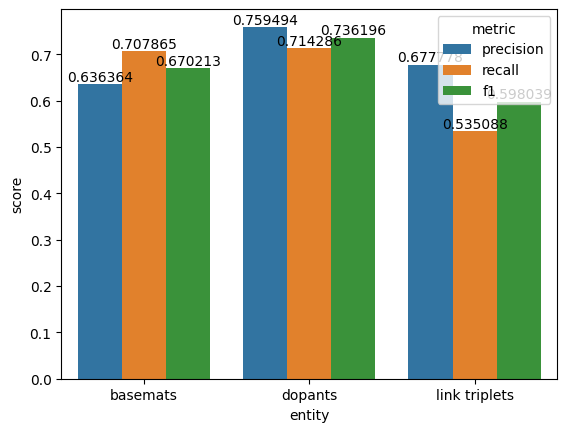

<Figure size 640x480 with 0 Axes>

In [ ]:
# ACTIVE LEARNING EVAL
step3_score.main(
    test_file=test_dataset_path_local,
    pred_file=os.path.join(active_learning_dir, "fewshot2output.json"),
    plot=True,
    loud=True,
    schema_type=True,
    enforce_lowercase=False,
    output_dir=active_learning_dir
)

## Synthetic Data

In [ ]:
# SYNTH JSON TRAINING
torch.cuda.empty_cache()
synthetic_data.main(
    model_id = model_id,
    dataset_path = dataset_path,
    mode = "synth_json",
    output_dir = synth_json_dir,
    bnb_dict = None,
    peft_dict = None,
    sft_dict = sft_synth_json,
    model_dict = None,
    generation_dict = None,
)

In [ ]:
# SYNTH JSON INFERENCE
torch.cuda.empty_cache()
few_shot_inference.main(
    model_id=synth_json_dir,
    dataset_path=dataset_path,
    inference_dataset_path=dataset_path,
    mode="synth_json",
    output_dir=synth_json_dir, # TODO: fix this
    bnb_dict={},#None
    model_dict=model_dict,
    generation_dict=generation_dict,
    quick_mode=quick_mode
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

training dataset sample: {'prompt': 'Dual-reflected-structure erbium-doped fiber laser in single-longitudinal- mode for wavelength-tu', 'completion': ' {\n "basemats": {\n  "b0": "fiber laser"\n },\n "dopants": {\n  "d0": "erbium"\n },\n "dopants2basemats": {\n  "d0": [\n   "b0"\n  ]\n }\n}', 'messages': [{'content': 'You are a helpful assistant that generates json. Respond with the exact answer only, no explanations or prefixes. Here are some examples:\n user Give me a sample json of basemats, dopands and dopants2basemats. \n assistant  {\n "basemats": {\n  "b0": "YAG"\n },\n "dopants": {\n  "d0": "Nd"\n },\n "dopants2basemats": {\n  "d0": [\n   "b0"\n  ]\n }\n}\n\n user Give me a sample json of basemats, dopands and dopants2basemats. \n assistant  {\n "basemats": {\n  "b0": "diamond-like carbon",\n  "b1": "DLC"\n },\n "dopants": {\n  "d0": "nitrogen",\n  "d1": "N",\n  "d2": "nickel",\n  "d3": "Ni"\n },\n "dopants2basemats": {\n  "d0": [\n   "b0"\n  ],\n  "d1": [\n   "b0",\n   "b1"\n 

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Original Output: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a helpful assistant that generates json. Respond with the exact answer only, no explanations or prefixes. Here are some examples:
 user Give me a sample json of basemats, dopands and dopants2basemats. 
 assistant  {
 "basemats": {
  "b0": "YAG"
 },
 "dopants": {
  "d0": "Nd"
 },
 "dopants2basemats": {
  "d0": [
   "b0"
  ]
 }
}

 user Give me a sample json of basemats, dopands and dopants2basemats. 
 assistant  {
 "basemats": {
  "b0": "diamond-like carbon",
  "b1": "DLC"
 },
 "dopants": {
  "d0": "nitrogen",
  "d1": "N",
  "d2": "nickel",
  "d3": "Ni"
 },
 "dopants2basemats": {
  "d0": [
   "b0"
  ],
  "d1": [
   "b0",
   "b1"
  ],
  "d2": [
   "b0"
  ],
  "d3": [
   "b0",
   "b1"
  ]
 }
}
 Now your turn.<|eot_id|><|start_header_id|>user<|end_header_id|>

Give me a sample json of basemats, dopands and dopants2basemats.<|eot_id|><|start_he

100%|██████████| 100/100 [12:21<00:00,  7.42s/it]


In [ ]:
# SYNTH SPAN TRAINING
torch.cuda.empty_cache()
synthetic_data.main(
    model_id = model_id,
    dataset_path = dataset_path,
    mode = "synth_span",
    output_dir = synth_span_dir,
    bnb_dict = None,
    peft_dict = None,
    sft_dict = extraction_sft,
    model_dict = None,
    generation_dict = None,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Original Output: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 Dec 2024

You are an expert writer. I will give you a json and you will give me a sentence containing its elements. In other words, if you were asked to extract the doping information from the sentence you created it should extract the json I give you. Respond with the exact answer only, no explanations or prefixes. Be concise.<|eot_id|><|start_header_id|>user<|end_header_id|>

{
 "basemats": {
  "b0": "diamond-like carbon",
  "b1": "DLC"
 },
 "dopants": {
  "d0": "nitrogen",
  "d1": "N",
  "d2": "nickel",
  "d3": "Ni"
 },
 "dopants2basemats": {
  "d0": [
   "b0"
  ],
  "d1": [
   "b0",
   "b1"
  ],
  "d2": [
   "b0"
  ],
  "d3": [
   "b0",
   "b1"
  ]
 }
}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The material contains diamond-like carbon (b0) and DLC (b1) and is doped with nitrogen (d0), N (d1), nickel (d2), and Ni (d3).


Map:   0%|          | 0/90 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,3.385800
20,2.554600
30,1.889200
40,1.311300
50,0.781400
60,0.461100
70,0.340900
80,0.223000
90,0.167700
100,0.123400


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/

Finetuned Output: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 Dec 2024

You are an expert writer. I will give you a json and you will give me a sentence containing its elements. In other words, if you were asked to extract the doping information from the sentence you created it should extract the json I give you. Respond with the exact answer only, no explanations or prefixes. Be concise.<|eot_id|><|start_header_id|>user<|end_header_id|>

{
 "basemats": {
  "b0": "diamond-like carbon",
  "b1": "DLC"
 },
 "dopants": {
  "d0": "nitrogen",
  "d1": "N",
  "d2": "nickel",
  "d3": "Ni"
 },
 "dopants2basemats": {
  "d0": [
   "b0"
  ],
  "d1": [
   "b0",
   "b1"
  ],
  "d2": [
   "b0"
  ],
  "d3": [
   "b0",
   "b1"
  ]
 }
}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

In this paper the effect of surface properties of micromolds on replication process was investigated by using nitrogen (N) and nickel (Ni) doped d

In [ ]:
# SYNTHETIC SPAN INFERENCE
torch.cuda.empty_cache()
few_shot_inference.main(
    model_id=synth_span_dir,
    dataset_path=dataset_path,
    inference_dataset_path=os.path.join(synth_json_dir, "few_shot_output.jsonl"),
    mode="synth_span",
    output_dir=synth_span_dir,
    bnb_dict={},
    model_dict=model_dict,
    generation_dict=generation_dict,
    quick_mode=False
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

training dataset sample: {'prompt': 'Dual-reflected-structure erbium-doped fiber laser in single-longitudinal- mode for wavelength-tu', 'completion': '{\n "basemats": {\n  "b0": "silicon",\n  "b1": "silicon"\n },\n "dopants": {\n  "d0": "boron",\n  "d1": "B",\n  "d2": "boron"\n },\n "dopants2basemats": {\n  "d0": [\n   "b0",\n   "b1"\n  ],\n  "d1": [\n   "b0",\n   "b1"\n  ],\n  "d2": [\n   "b0",\n   "b1"\n  ]\n }\n}', 'messages': [{'content': 'You are an expert writer. I will give you a json and you will give me a sentence containing its elements. In other words, if you were asked to extract the doping information from the sentence you created it should extract the json I give you. Respond with the exact answer only, no explanations or prefixes. Be concise. Here are some examples:\n user  {\n "basemats": {\n  "b0": "YAG"\n },\n "dopants": {\n  "d0": "Nd"\n },\n "dopants2basemats": {\n  "d0": [\n   "b0"\n  ]\n }\n} \n assistant Study of the influence of the Nd:YAG laser irradiation at 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Original Output: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 Dec 2024

You are an expert writer. I will give you a json and you will give me a sentence containing its elements. In other words, if you were asked to extract the doping information from the sentence you created it should extract the json I give you. Respond with the exact answer only, no explanations or prefixes. Be concise. Here are some examples:
 user  {
 "basemats": {
  "b0": "YAG"
 },
 "dopants": {
  "d0": "Nd"
 },
 "dopants2basemats": {
  "d0": [
   "b0"
  ]
 }
} 
 assistant Study of the influence of the Nd:YAG laser irradiation at 1.3μm on the thermal–mechanical–optical parameters of germaniu

 user  {
 "basemats": {
  "b0": "diamond-like carbon",
  "b1": "DLC"
 },
 "dopants": {
  "d0": "nitrogen",
  "d1": "N",
  "d2": "nickel",
  "d3": "Ni"
 },
 "dopants2basemats": {
  "d0": [
   "b0"
  ],
  "d1": [
   "b0",
   "b1"
  ],
  "d2": [
   "b0"
  ],
  

100%|██████████| 100/100 [26:43<00:00, 16.04s/it]


In [ ]:
# score uncertainty of synthetic spans
# (scores currently not used but could be in the future)
torch.cuda.empty_cache()
uq_score.main(
    model_id = model_id,
    dataset_path = os.path.join(synth_span_dir, "few_shot_output.jsonl"),
    mode = "synth_span",
    output_dir = synth_span_dir_final,
    uq_metric = "calculate_perplexity_raw",
)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
experiment_sampling.main(
    dataset_path = dataset_path,
    sampling_mode = "synth_span",
    output_dir = synth_span_dir_final,
    budget = 100,
)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# SYNTH EXTRACTION TRAINING
torch.cuda.empty_cache()
synthetic_data.main(
    model_id = model_id,
    dataset_path = os.path.join(synth_span_dir_final, "train_dataset.jsonl"),
    mode = "extraction",
    output_dir = synth_span_dir_final,
    bnb_dict = bnb_dict,
    peft_dict = peft_dict,
    sft_dict = sft_dict,
    model_dict = model_dict,
    generation_dict = generation_dict,
)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:452: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Original Output: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 Dec 2024

Extract doping information from this sentence into a json. Respond with the exact answer only, no explanations or prefixes.<|eot_id|><|start_header_id|>user<|end_header_id|>

Ultraviolet (UV) light exposure at 254 nm and 365 nm significantly affected the structural and optoelectronic properties of Sb-doped SnO2 nanoparticles films prepared by sol–gel processing at different pH values of the sol-gel precursor solution. The existence of one P-I transition, one N–N* transition and one f–f transition suggested the presence of one f–doped SnO2 with the pseudogap arounfilled with one e–doped SnO2 and one N–doped SnO2 nanoparticles. The existence of one N–N* transition and one f–f transition suggested the presence of one f–doped SnO2 with the pseudogap arounfilled with one<|eot_id|><|start_header_id|>assistant<|end_header_id|>

```
{
  "doping_methods": 

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,0.577600
20,0.141000
30,0.136400
40,0.109500
50,0.077900
60,0.059700
70,0.075800
80,0.046200
90,0.068900
100,0.034800


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/

Finetuned Output: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 10 Dec 2024

Extract doping information from this sentence into a json. Respond with the exact answer only, no explanations or prefixes.<|eot_id|><|start_header_id|>user<|end_header_id|>

Ultraviolet (UV) light exposure at 254 nm and 365 nm significantly affected the structural and optoelectronic properties of Sb-doped SnO2 nanoparticles films prepared by sol–gel processing at different pH values of the sol-gel precursor solution. The existence of one P-I transition, one N–N* transition and one f–f transition suggested the presence of one f–doped SnO2 with the pseudogap arounfilled with one e–doped SnO2 and one N–doped SnO2 nanoparticles. The existence of one N–N* transition and one f–f transition suggested the presence of one f–doped SnO2 with the pseudogap arounfilled with one<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{
 "basemats": {
  "b0": 

In [ ]:
# SYNTH EXTRACTION INFERENCE
torch.cuda.empty_cache()
few_shot_inference_extraction.main(
    model_id=synth_span_dir_final,
    dataset_path=os.path.join(random_baseline_dir, "train_dataset.jsonl"),
    inference_dataset_path=test_dataset_path,
    mode="extraction",
    output_dir=synth_span_dir_final,
    bnb_dict=bnb_dict,
    model_dict=model_dict,
    generation_dict=generation_dict,
    quick_mode=quick_mode
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

 75%|███████▌  | 6/8 [00:26<00:07,  3.64s/it]/usr/local/lib/python3.10/dist-packages/doping/step2_train_predict.py:158: UserWarning: Could not json decode entry '{
 "basemats": {
  "b0": "ITO"
 },
 "dopants": {
  "d0": "ZnO"
 },
 "dopants2basemats": {
  "d0": [
   "b0"
  ]
 }
}

{
 "basemats": {
  "b0": "ITO"
 },
 "dopants": {
  "d0": "ZnO"
 },
 "dopants2basemats": {
  "d0": [
   "b0"
  ]
 }
}

{
 "basemats": {
  "b0": "ITO"
 },
 "dopants": {
  "d0": "ZnO"
 }'
  warnings.warn(f"Could not json decode entry '{text}'")

 17%|█▋        | 1/6 [00:06<00:34,  6.89s/it]/usr/local/lib/python3.10/dist-packages/doping/step2_train_predict.py:158: UserWarning: Could not json decode entry '{
 "basemats": {
  "b0": "CaF2"
 },
 "dopants": {
  "d0": "ce",
  "d1": "Pr",
  "d2": "Sm",
  "d3": "Eu",
  "d4": "Gd",
  "d5": "Tb",
  "d6": "Dy",
  "d7": "Ho",
  "d8"

Scoring outputs using 
	test file: /content/drive/MyDrive/nlp/Final_project/NERRE/doping/data/test.json
	pred file: /content/drive/MyDrive/nlp/Final_project/IE-UQ/runs/synth_span_gen-llama3b_10_final_ep/fewshot2output.json
Comparison of chemical bath-deposited ZnO films doped with Al, Ga and In.
{'basemats': {'b0': 'ZnO'},
 'dopants': {'d0': 'Al', 'd1': 'Ga', 'd2': 'In'},
 'dopants2basemats': {'d0': ['b0'], 'd1': ['b0'], 'd2': ['b0']}}
{'basemats': {'b0': 'ZnO'},
 'dopants': {'d0': 'Al', 'd1': 'Ga', 'd2': 'In'},
 'dopants2basemats': {'d0': ['b0'], 'd1': ['b0'], 'd2': ['b0']}}
basemats {'basemats': {'b0': 'ZnO'}, 'dopants': {'d0': 'Al', 'd1': 'Ga', 'd2': 'In'}, 'dopants2basemats': {'d0': ['b0'], 'd1': ['b0'], 'd2': ['b0']}}
dopants {'basemats': {'b0': 'ZnO'}, 'dopants': {'d0': 'Al', 'd1': 'Ga', 'd2': 'In'}, 'dopants2basemats': {'d0': ['b0'], 'd1': ['b0'], 'd2': ['b0']}}
Sequences differ:
{
 "basemats": {
  "b0": "ZnO"
 },
 "dopants": {
  "d0": "Al",
  "d1": "Ga",
  "d2": "In"
 },
 "dopa

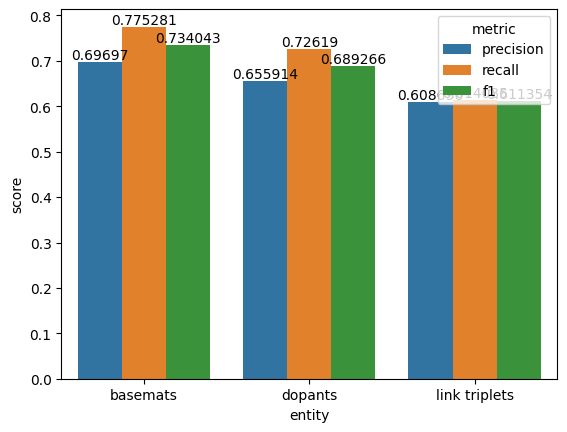

<Figure size 640x480 with 0 Axes>

In [ ]:
# SYNTH EXTRACTION EVAL
step3_score.main(
    test_file=test_dataset_path_local,
    pred_file=os.path.join(synth_span_dir_final, "fewshot2output.json"),
    plot=True,
    loud=True,
    schema_type=True,
    enforce_lowercase=False,
    output_dir=synth_span_dir_final)

In [ ]:
print("Pipeline done")

# Shut down the Colab instance after execution
from google.colab import runtime
runtime.unassign()